# Normalzing Flows

ORCA Group Meeting February 24, 2022

(add short url)

(add colab url)

# Quick Notes

- Interrupt and ask questions
- This is a jupyter notebook and so 
[managing state](https://jupytearth.org/jupyter-resources/ecosystem/managing-state.html) is 
the price of doing business, becareful if you start jumping around in the notebook
- Normalizing Flows touch a few differen topics I am going to try to add references that expand on a topic by 
embeding a link in the text. For example, in this notebook we are going to use 
[Tensorflow](https://www.tensorflow.org).
- If something has more than one reference link, I'll embed the additional links using 🤔. 
For example, we will also be using [Tensorflow Probabiliy](https://www.tensorflow.org/probability/)
[🤔](https://www.tensorflow.org/probability/overview).

In [85]:
# This limits the tensorflow output log 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# These are the imports we'll need today
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# local python file
import plot_helpers as ph

# Probabiliy Distributions

- [Probability distributions](https://en.wikipedia.org/wiki/Probability_distribution#:~:text=A%20probability%20distribution%20is%20a%20mathematical%20description%20of,vectors%2C%20a%20set%20of%20arbitrary%20non-numerical%20values%2C%20etc.) are a function that tell us how probable certain some event $x$ is.
- There are many kinds of probability distributions and covering all of the basics is a course in and of 
itself, but I will add links as we go along to topics
- For today, we are going to use the [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution)

# Normal Distribution

The [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution)
[🤔](https://www.youtube.com/watch?v=hgtMWR3TFnY) is a well studied and widely used
probability distribution that is parameterized by two values $\mu$ and $\sigma^2$, which are the 
mean(location) and variance(squared scale) respectively and commonly written as 
$\mathcal{N}(\mu,\sigma^2)$. The 
[probability density function](https://en.wikipedia.org/wiki/Probability_density_function) for the normal
distribution is described below:

$$f_{\mu,\sigma^2}(x)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$$
<center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/7/74/Normal_Distribution_PDF.svg"/>
</center>

# Normal Distribution - In Code

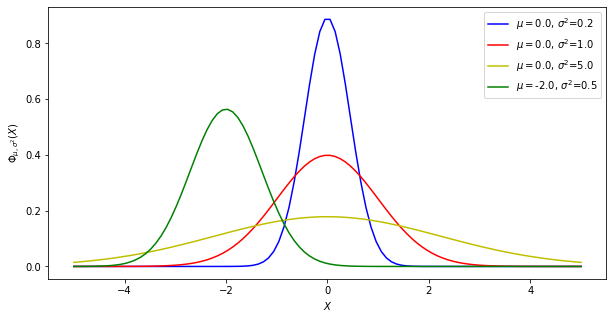

In [48]:
locations_mus = [0.0, 0.0, 0.0, -2.0]
scales_sigma2 = [0.2, 1.0, 5.0,  0.5]

xs = tf.linspace(-5.0, 5.0, num=100)
plt.figure(figsize=(10,5))
for l,s,c in zip(locations_mus, scales_sigma2, "bryg"):
    n=tfd.Normal(loc=l, scale=tf.math.sqrt(s))
    plt.plot(xs, n.prob(xs), c=c, label=f"$\mu=${l}, $\sigma^2$={s}")
plt.xlabel("$X$");plt.ylabel("$\Phi_{\mu,\sigma^2}(X)$");plt.legend();plt.show()

# Normal Distribution - In Code

Some x: [0.9511575102806091, -0.5284624695777893]
Relative liklihood of x: [0.25377967953681946, 0.3469499349594116]


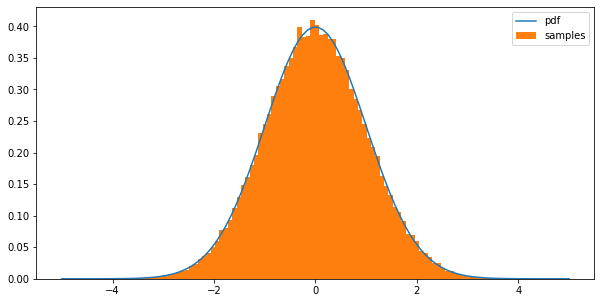

In [101]:
normal = tfd.Normal(loc=0, scale=1)
samples = normal.sample(100000)
some_samples = samples[:2].numpy().tolist()
print("Some x:", some_samples)
print("Relative liklihood of x:", normal.prob(some_samples).numpy().tolist())
xs = tf.linspace(-5.0, 5.0, num=100)
ph.hist_with_pdf(samples, normal)

# 2D - Mutivariate Normal Distribution

So far have seen the Normal distribution in one dimension but it can be 
[multidimensional](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) as well,
where $\mu$ is now a vector $\mathbf{\mu} \in \mathcal{R}^d$ and $\sigma$ becomes the
[covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) $\mathbf{\Sigma}$ 
and the notation for the distribution becomes 
$\mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})$

<center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8e/MultivariateNormal.png/793px-MultivariateNormal.png"/>
<cemter>

# 2D - Mutivariate Normal Distribution - In Code

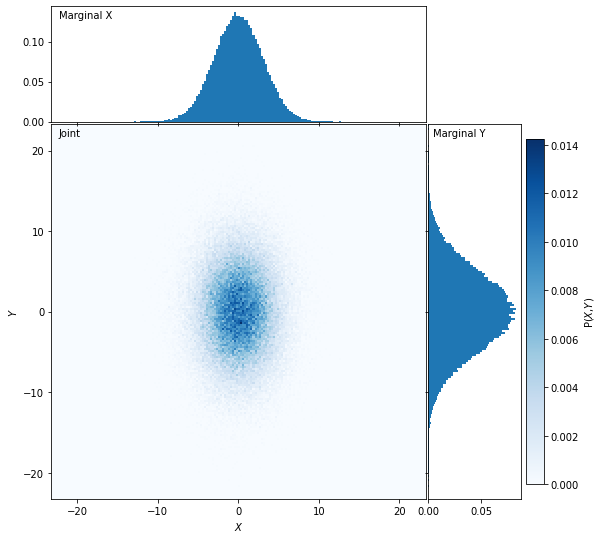

In [99]:
normal_2d = tfd.MultivariateNormalDiag(loc=[0,0], scale_diag=[3, 5])
samples = normal_2d.sample(100000).numpy()
ph.hist2d_marginals(samples[:,0], samples[:,1])

# Why Is This Important?

- If we find that our 
[data is normally distributed](https://www.statology.org/example-of-normal-distribution/), 
that is distributed like Normal Distribution, then we use the normal distribution to 
describe our data and even draw new samples!
- But what if our data is not normally distributed? ...then 

<center><img src="https://gifimage.net/wp-content/uploads/2017/07/game-over-gif-26.gif"/></center>

# Not Quite! But first we need some tools.

- We can use the change of variables applied to the probablily distributions
- Suppose we have a random variable $X \in \mathcal{R}^d$ and an invertible 
bijective transformation $f: \mathcal{R}^d \mapsto \mathcal{R}^d$ that when applied
to $X$ produces a new random variable $Z$


